In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

%load_ext autoreload
%autoreload 2
import notebook_setup

Project root added to path: d:\google_drive\Мой диск\projects\BRepMocAutoencoder


In [2]:
from src.config import PROCESSED_DATA_DIR
from src.data import BrepNetDataset, moco_collate_fn, simple_collate_fn
from torch.utils.data import DataLoader
STATS_BREPNET = PROCESSED_DATA_DIR / "dataset_stats.json"

BREP_NPZ_DIR = PROCESSED_DATA_DIR / "features" / "brep"

train_dataset = BrepNetDataset(STATS_BREPNET, BREP_NPZ_DIR, split="training_set")
val_dataset = BrepNetDataset(STATS_BREPNET, BREP_NPZ_DIR, split="validation_set")
test_dataset = BrepNetDataset(STATS_BREPNET, BREP_NPZ_DIR, split="test_set")


train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=moco_collate_fn,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=simple_collate_fn,
    num_workers=0
)

2025-10-06 00:25:56.347 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: D:\google_drive\Мой диск\projects\BRepMocAutoencoder


In [3]:
import torch
from torch.nn import Linear, Sequential, ModuleList, BatchNorm1d, Dropout, LeakyReLU, ReLU
import torch_geometric.nn.conv.gat_conv as gat_conv
from torch_geometric.utils import add_self_loops


class CustomBRepEncoder(torch.nn.Module):
    def __init__(self, 
                 v_in_width, 
                 e_in_width, 
                 f_in_width, 
                 out_width, 
                 num_layers, 
                 use_attention=False,
                 dropout=0.0):
        """
        BRep граф энкодер с иерархической агрегацией признаков.
        """
        super().__init__()
        self.use_attention = use_attention
        self.out_width = out_width

        # Входные эмбеддинги
        self.embed_v_in = LinearBlock(v_in_width, out_width, dropout=dropout)
        self.embed_e_in = LinearBlock(e_in_width, out_width, dropout=dropout)
        self.embed_f_in = LinearBlock(f_in_width, out_width, dropout=dropout)

        # Слои передачи информации по иерархии графа
        self.V2E = BipartiteResMRConv(out_width, batch_norm=True, dropout=dropout)
        self.E2F = BipartiteResMRConv(out_width, batch_norm=True, dropout=dropout)

        # Слои message passing между гранями
        if self.use_attention:
            self.message_layers = ModuleList([
                gat_conv.GATConv(out_width, out_width//4, heads=4) 
                for _ in range(num_layers)
            ])
        else:
            self.message_layers = ModuleList([
                BipartiteResMRConv(out_width, batch_norm=True, dropout=dropout) 
                for _ in range(num_layers)
            ])

    def forward(self, data):
        """
        Прямой проход через энкодер.
        Поддерживает и батчи (Batch), и одиночные графы (dict).
        """
        # Проверка на пустые данные
        if data.vertices.numel() == 0 or data.edges.numel() == 0 or data.faces.numel() == 0:
            return torch.empty((0, self.out_width), device=data.vertices.device, dtype=data.vertices.dtype)

        # 1. Эмбеддинги
        x_v = self._sanitize(self.embed_v_in(data.vertices))
        x_e = self._sanitize(self.embed_e_in(data.edges))
        x_f = self._sanitize(self.embed_f_in(data.faces))

        # 2. Построение иерархии: Вершины → Рёбра
        e_v = data.edge_to_vertex.long().contiguous()
        x_e = self._sanitize(self.V2E(x_v, x_e, e_v))

        # 3. Рёбра → Грани (используем списки face_to_edge)
        if hasattr(data, 'face_to_edge_list'):
            # Для батчей: обрабатываем каждый граф отдельно
            x_f = self._process_edge_to_face_batch(x_e, x_f, data)
        else:
            # Для одиночного графа
            f_e = data.face_to_edge.long().contiguous()
            if f_e.numel() > 0 and f_e.size(1) > 0:
                x_f = self._sanitize(self.E2F(x_e, x_f, torch.stack([f_e[1], f_e[0]], dim=0)))

        # 4. Message passing между гранями (только self-loops)
        nf = x_f.size(0)
        f_f, _ = add_self_loops(
            torch.empty(2, 0, dtype=torch.long, device=x_f.device), 
            num_nodes=nf
        )

        for layer in self.message_layers:
            if self.use_attention:
                x_f = self._sanitize(layer(x_f, f_f))
            else:
                x_f = self._sanitize(layer(x_f, x_f, f_f))

        return x_f

    def _process_edge_to_face_batch(self, x_e, x_f, data):
        """
        Обработка face_to_edge для батча графов.
        """
        # Проверяем наличие edges_batch
        if not hasattr(data, 'edges_batch'):
            raise AttributeError(
                "Batch object missing 'edges_batch'. "
                "Ensure collate_fn creates this attribute."
            )
        
        # Вычисляем количество рёбер и граней в каждом графе
        edges_per_graph = torch.bincount(data.edges_batch, minlength=data.num_graphs)
        faces_per_graph = torch.bincount(data.faces_batch, minlength=data.num_graphs)
        
        # Вычисляем начальные индексы (ИСПРАВЛЕНО: добавлен device и dtype)
        edge_offsets = torch.cat([
            torch.zeros(1, device=edges_per_graph.device, dtype=edges_per_graph.dtype), 
            edges_per_graph.cumsum(0)[:-1]
        ])
        face_offsets = torch.cat([
            torch.zeros(1, device=faces_per_graph.device, dtype=faces_per_graph.dtype), 
            faces_per_graph.cumsum(0)[:-1]
        ])
        
        # Обрабатываем каждый граф
        updated_faces = []
        
        for graph_idx in range(data.num_graphs):
            f_e = data.face_to_edge_list[graph_idx].long()
            
            if f_e.numel() == 0 or f_e.size(1) == 0:
                # Нет связей - берём грани как есть
                start_face = int(face_offsets[graph_idx])
                end_face = start_face + int(faces_per_graph[graph_idx])
                updated_faces.append(x_f[start_face:end_face])
                continue
            
            # Извлекаем рёбра и грани для этого графа
            start_edge = int(edge_offsets[graph_idx])
            end_edge = start_edge + int(edges_per_graph[graph_idx])
            start_face = int(face_offsets[graph_idx])
            end_face = start_face + int(faces_per_graph[graph_idx])
            
            x_e_graph = x_e[start_edge:end_edge]
            x_f_graph = x_f[start_face:end_face]
            
            # f_e имеет формат [edge_idx, face_idx], локальные индексы
            # Транспонируем для BipartiteResMRConv: [face_idx, edge_idx]
            f_e_local = torch.stack([f_e[1], f_e[0]], dim=0)
            
            x_f_updated = self._sanitize(self.E2F(x_e_graph, x_f_graph, f_e_local))
            updated_faces.append(x_f_updated)
        
        return torch.cat(updated_faces, dim=0)

    @staticmethod
    def _sanitize(x: torch.Tensor) -> torch.Tensor:
        """Защита от NaN и Inf значений."""
        return torch.clamp(
            torch.nan_to_num(x, nan=0.0, posinf=1e4, neginf=-1e4), 
            -1e4, 1e4
        )


class BipartiteResMRConv(torch.nn.Module):
    """Двудольная свёртка с residual connection."""
    
    def __init__(self, width, batch_norm=True, dropout=0.0):
        super().__init__()
        self.mlp = LinearBlock(2 * width, width, batch_norm=batch_norm, dropout=dropout)
        self.width = width

    def forward(self, x_src, x_dst, edge_index):
        if x_dst.numel() == 0 or x_src.numel() == 0 or edge_index.numel() == 0:
            if x_dst.numel() > 0:
                return x_dst
            return torch.empty((0, self.width), device=x_dst.device, dtype=x_dst.dtype)

        diffs = torch.index_select(x_dst, 0, edge_index[1]) - torch.index_select(x_src, 0, edge_index[0])
        aggr = torch.zeros_like(x_dst)
        aggr.index_add_(0, edge_index[1], diffs)
        combined = torch.cat([x_dst, aggr], dim=1)
        output = x_dst + self.mlp(combined)

        return output


class LinearBlock(torch.nn.Module):
    """Базовый линейный блок."""
    
    def __init__(self, *layer_sizes, batch_norm=True, dropout=0.0, last_linear=False, leaky=True):
        super().__init__()
        layers = []
        
        for i in range(len(layer_sizes) - 1):
            c_in = layer_sizes[i]
            c_out = layer_sizes[i + 1]
            layers.append(Linear(c_in, c_out))
            
            if last_linear and i + 1 >= len(layer_sizes) - 1:
                break
                
            if batch_norm:
                layers.append(BatchNorm1d(c_out))
            if dropout > 0:
                layers.append(Dropout(p=dropout))
            layers.append(LeakyReLU() if leaky else ReLU())
            
        self.f = Sequential(*layers)
        self.out_features = layer_sizes[-1]

    def forward(self, x):
        if x.numel() == 0:
            return torch.empty((0, self.out_features), device=x.device, dtype=x.dtype)
        return self.f(x)

In [4]:
import torch
import torch.nn as nn

class ConditionalDecoder(nn.Module):
    def __init__(self,
                 latent_size,
                 hidden_dims = [1024, 1024, 1024, 1024],
                 uv_input_dim=2,
                 output_dim=4 ):
        """
        Инициализация условного декодера.
        Args:
            latent_size (int): Размерность выходного латентного вектора энкодера.
            hidden_dims (list of int): Список размеров скрытых слоев.
            uv_input_dim (int): Размерность входных (u, v) координат. По умолчанию 2.
            output_dim (int): Размерность выходных данных. По умолчанию 4 (x, y, z, d).
        """
        super().__init__()
        self.latent_size = latent_size
        self.uv_input_dim = uv_input_dim
        self.output_dim = output_dim

        # Входные данные: латентный вектор и (u, v) координаты, размер latent_size + uv_input_dim
        input_dim = latent_size + uv_input_dim

        # Построение полносвязных слоев
        layers = []
        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, uv_coords, latent_vector):
        """
        Прямой проход через декодер.
        Args:
            uv_coords (torch.Tensor): Тензор (u, v) координат формы [N, 2].
            latent_vector (torch.Tensor): Латентный вектор формы [N, D] или [D].
        """
        # Проверяем размерность latent_vector
        if latent_vector.dim() == 1:
            # Если latent_vector одномерный [D], расширяем и повторяем
            latent_vector = latent_vector.unsqueeze(0).repeat(uv_coords.shape[0], 1)
        elif latent_vector.dim() == 2:
            # Если latent_vector уже батч [N, D], проверяем соответствие размера
            assert latent_vector.shape[0] == uv_coords.shape[0], \
                f"Batch size mismatch: latent_vector {latent_vector.shape[0]} vs uv_coords {uv_coords.shape[0]}"
        else:
            raise ValueError(f"Unexpected latent_vector dimensions: {latent_vector.dim()}")

        # Объединение латентного вектора и (u, v) координат
        x = torch.cat([latent_vector, uv_coords], dim=-1)

        # Пропуск через полносвязную сеть
        output = self.network(x)
        return output

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch_geometric.nn import global_mean_pool
import copy


class BRepMoCoAutoencoder(pl.LightningModule):
    def __init__(self,
                 v_in_width=3,
                 e_in_width=10,
                 f_in_width=7,
                 encoder_out_width=256,
                 encoder_num_layers=4,
                 decoder_hidden_dims=[512, 512, 256, 128],
                 decoder_uv_input_dim=2,
                 decoder_output_dim=1,
                 learning_rate=1e-4,
                 reconstruction_weight=1.0,
                 contrastive_weight=0.5,
                 temperature=0.07,
                 moco_momentum=0.999,
                 queue_size=65536,
                 moco_dim=128,
                 weight_decay=1e-6,
                 use_attention=False,
                 dropout=0.1,
                 epochs=100):
        """
        BRep MoCo Autoencoder (ИСПРАВЛЕННАЯ ВЕРСИЯ по оригинальному MoCo).
        """
        super().__init__()
        self.save_hyperparameters()

        # Энкодеры (query и key) - ОБЩИЙ базовый энкодер
        self.encoder_q = CustomBRepEncoder(
            v_in_width=v_in_width,
            e_in_width=e_in_width,
            f_in_width=f_in_width,
            out_width=encoder_out_width,
            num_layers=encoder_num_layers,
            use_attention=use_attention,
            dropout=dropout
        )
        
        # Key encoder - копия query encoder (не обновляется градиентами)
        self.encoder_k = copy.deepcopy(self.encoder_q)
        for param in self.encoder_k.parameters():
            param.requires_grad = False

        # Проекции для контрастивной потери (moco_dim)
        # Это ЧАСТЬ энкодера, а не отдельная "голова"
        self.fc_q = nn.Linear(encoder_out_width, moco_dim)
        self.fc_k = copy.deepcopy(self.fc_q)
        for param in self.fc_k.parameters():
            param.requires_grad = False

        # Декодер (использует ПОЛНЫЙ латент encoder_out_width)
        self.decoder = ConditionalDecoder(
            latent_size=encoder_out_width,
            hidden_dims=decoder_hidden_dims,
            uv_input_dim=decoder_uv_input_dim,
            output_dim=decoder_output_dim
        )

        # Очередь в формате [moco_dim, K] как в оригинальном MoCo
        self.register_buffer("queue", torch.randn(moco_dim, queue_size))
        self.queue = F.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

        # Функции потерь
        self.reconstruction_criterion = nn.MSELoss()


    def forward(self, data):
        """Прямой проход автоэнкодера."""
        # Энкодирование
        face_features = self.encoder_q(data)
        
        if face_features.numel() == 0:
            return [], [], None
        
        # Глобальный латент модели (ПОЛНАЯ размерность encoder_out_width)
        model_latent = global_mean_pool(
            face_features, 
            data.faces_batch, 
            size=data.num_graphs
        )  # [batch_size, encoder_out_width]
        
        # Декодирование (реконструкция SDF)
        reconstructed_sdf_list = []
        target_sdf_list = []
        
        if not hasattr(data, 'sdf_uv_list') or not hasattr(data, 'sdf_vals_list'):
            return reconstructed_sdf_list, target_sdf_list, model_latent
        
        # Для каждого графа в батче
        for graph_idx in range(data.num_graphs):
            sdf_uv = data.sdf_uv_list[graph_idx].view(-1, 2)
            sdf_vals = data.sdf_vals_list[graph_idx].view(-1)
            
            graph_latent = model_latent[graph_idx:graph_idx+1]
            latent_repeated = graph_latent.repeat(sdf_uv.size(0), 1)
            
            reconstructed_sdf = self.decoder(sdf_uv, latent_repeated).squeeze(-1)
            
            reconstructed_sdf_list.append(reconstructed_sdf)
            target_sdf_list.append(sdf_vals)
        
        return reconstructed_sdf_list, target_sdf_list, model_latent


    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """Momentum update ключевого энкодера."""
        m = self.hparams.moco_momentum
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * m + param_q.data * (1. - m)
        for param_q, param_k in zip(self.fc_q.parameters(), self.fc_k.parameters()):
            param_k.data = param_k.data * m + param_q.data * (1. - m)


    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        """Обновление очереди (формат [moco_dim, K])."""
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)

        if batch_size > self.hparams.queue_size:
            return

        # Нормализуем и транспонируем ключи
        keys = F.normalize(keys, dim=1).T

        if ptr + batch_size > self.hparams.queue_size:
            space_to_end = self.hparams.queue_size - ptr
            overflow = batch_size - space_to_end
            self.queue[:, ptr:] = keys[:, :space_to_end]
            self.queue[:, :overflow] = keys[:, space_to_end:]
            ptr = overflow
        else:
            self.queue[:, ptr:ptr + batch_size] = keys
            ptr = ptr + batch_size

        self.queue_ptr[0] = ptr % self.hparams.queue_size


    def contrastive_loss(self, im_q, im_k):
        """
        InfoNCE loss (как в оригинальном MoCo).
        
        Args:
            im_q: Проекции запросов [batch_size, moco_dim]
            im_k: Проекции ключей [batch_size, moco_dim]
        """
        # Нормализация
        q = F.normalize(im_q, dim=1)  # [N, moco_dim]
        k = F.normalize(im_k, dim=1)  # [N, moco_dim]
        
        # Позитивные пары
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)  # [N, 1]
        
        # Негативные пары с очередью формата [moco_dim, K]
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])  # [N, K]
        
        # Объединяем
        logits = torch.cat([l_pos, l_neg], dim=1)  # [N, 1 + K]
        logits /= self.hparams.temperature
        
        # Целевые метки
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)
        
        loss = F.cross_entropy(logits, labels)
        return loss


    def training_step(self, batch, batch_idx):
        """Шаг обучения."""
        data_q, data_k = batch
        
        # 1. Реконструкция (query)
        reconstructed_list_q, target_list_q, latent_q = self.forward(data_q)
        
        if len(reconstructed_list_q) == 0:
            recon_loss = torch.tensor(0.0, device=self.device, requires_grad=True)
        else:
            losses = [
                self.reconstruction_criterion(recon, target)
                for recon, target in zip(reconstructed_list_q, target_list_q)
            ]
            recon_loss = torch.stack(losses).mean() * self.hparams.reconstruction_weight
        
        # 2. Контрастное обучение
        contrastive_loss = torch.tensor(0.0, device=self.device)
        
        if latent_q is not None and latent_q.shape[0] > 0:
            # Query: проекция на moco_dim
            q = self.fc_q(latent_q)  # [N, moco_dim]
            
            # Key: momentum encoder
            with torch.no_grad():
                # Shuffle для BatchNorm
                idx_shuffle = torch.randperm(data_k.num_graphs, device=self.device)
                shuffled_data_k = self._shuffle_graph_batch(data_k, idx_shuffle)
                
                face_features_k = self.encoder_k(shuffled_data_k)
                
                if face_features_k.numel() > 0:
                    latent_k = global_mean_pool(
                        face_features_k,
                        shuffled_data_k.faces_batch,
                        size=shuffled_data_k.num_graphs
                    )
                    k = self.fc_k(latent_k)  # [N, moco_dim]
                    
                    # Unshuffle
                    idx_unshuffle = torch.argsort(idx_shuffle)
                    k = k[idx_unshuffle]
                    
                    # if batch_idx % 500 == 0 and batch_idx > 0:
                    #     self.queue = torch.randn_like(self.queue)
                    #     self.queue = self.queue / self.queue.norm(dim=0, keepdim=True)
                    #     self.queue_ptr[0] = 0
                    
                    if batch_idx % 100 == 0:
                        q_norm = F.normalize(q, dim=1)
                        k_norm = F.normalize(k, dim=1)
                        pos_sim = (q_norm * k_norm).sum(dim=1).mean()
                        neg_sim = torch.einsum('nc,ck->nk', [q_norm, self.queue]).mean()

                        queue_norms = self.queue.norm(dim=0)
                        print(f"Step {batch_idx}: pos_sim={pos_sim:.4f}, neg_sim={neg_sim:.4f}, "
                                f"queue_norm_min={queue_norms.min():.4f}, queue_norm_max={queue_norms.max():.4f}")
                
                    # Контрастный лосс
                    contrastive_loss = self.contrastive_loss(q, k) * self.hparams.contrastive_weight
                    # Обновляем очередь
                    self._dequeue_and_enqueue(k)
        
        # Общая потеря
        total_loss = recon_loss + contrastive_loss
        
        # Логирование
        batch_size = data_q.num_graphs

        self.log('train_loss', total_loss, prog_bar=True, 
                 on_step=True, on_epoch=True, batch_size=batch_size)
        self.log('train_recon_loss', recon_loss, prog_bar=False, 
                 on_epoch=True, batch_size=batch_size)
        self.log('train_contrastive_loss', contrastive_loss, 
                 prog_bar=True, on_epoch=True, batch_size=batch_size)
        self.log('learning_rate', self.optimizers().param_groups[0]['lr'], 
                 prog_bar=False, on_step=True)
        
        return total_loss


    def on_train_batch_end(self, outputs, batch, batch_idx):
        """Momentum update после каждого батча."""
        self._momentum_update_key_encoder()


    def validation_step(self, batch, batch_idx):
        """Валидация."""
        data = batch
        
        with torch.no_grad():
            reconstructed_list, target_list, _ = self.forward(data)
            
            if len(reconstructed_list) == 0:
                loss = torch.tensor(0.0, device=self.device)
            else:
                losses = [
                    self.reconstruction_criterion(recon, target)
                    for recon, target in zip(reconstructed_list, target_list)
                ]
                loss = torch.stack(losses).mean()
        
        self.log('val_loss', loss, prog_bar=True, batch_size=data.num_graphs)
        return loss


    def configure_optimizers(self):
        """Оптимизатор."""
        parameters_to_optimize = (
            list(self.encoder_q.parameters()) +
            list(self.fc_q.parameters()) +
            list(self.decoder.parameters())
        )
        
        optimizer = torch.optim.Adam(
            parameters_to_optimize,
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.hparams.epochs,
            eta_min=1e-6
        )
        
        return [optimizer], [scheduler]


    @torch.no_grad()
    def _shuffle_graph_batch(self, batch, idx_shuffle):
        """Перемешивание графов в батче."""
        from torch_geometric.data import Batch
        
        data_list = batch.to_data_list()
        shuffled_data_list = [data_list[i] for i in idx_shuffle]
        
        # 1. Создаем новый батч из перемешанного списка.
        # PyG Batch корректно обработает тензоры (x, edge_index, edge_attr, face_attr)
        # и создаст для них правильные `ptr` и `batch` атрибуты.
        shuffled_batch = Batch.from_data_list(shuffled_data_list, follow_batch=['face_attr'])
        
        # 2. Вручную создаем `edges_batch`, так как PyG не делает это автоматически.
        edges_batch_list = []
        # ВАЖНО: итерируемся по НОВОМУ списку shuffled_data_list
        for graph_idx, data in enumerate(shuffled_data_list):
            num_edges = data.edge_attr.size(0)
            edges_batch_list.append(torch.full((num_edges,), graph_idx, dtype=torch.long, device=batch.x.device))
        
        if edges_batch_list:
            shuffled_batch.edges_batch = torch.cat(edges_batch_list)
        else:
            shuffled_batch.edges_batch = torch.empty(0, dtype=torch.long, device=batch.x.device)

        # 3. Переименовываем атрибуты для совместимости с энкодером.
        shuffled_batch.vertices = shuffled_batch.x
        shuffled_batch.edges = shuffled_batch.edge_attr
        shuffled_batch.faces = shuffled_batch.face_attr
        shuffled_batch.edge_to_vertex = shuffled_batch.edge_index
        shuffled_batch.faces_batch = shuffled_batch.face_attr_batch
        
        # 4. Перемешиваем списковые атрибуты, беря их из ИСХОДНОГО, но уже аугментированного батча `batch`.
        # Это самая важная часть исправления.
        if hasattr(batch, 'face_to_edge_list'):
            shuffled_batch.face_to_edge_list = [batch.face_to_edge_list[i] for i in idx_shuffle]
        if hasattr(batch, 'face_to_face_list'):
            shuffled_batch.face_to_face_list = [batch.face_to_face_list[i] for i in idx_shuffle]
        if hasattr(batch, 'sdf_uv_list'):
            shuffled_batch.sdf_uv_list = [batch.sdf_uv_list[i] for i in idx_shuffle]
        if hasattr(batch, 'sdf_vals_list'):
            shuffled_batch.sdf_vals_list = [batch.sdf_vals_list[i] for i in idx_shuffle]
        
        return shuffled_batch

In [23]:
moco_dim = 128
queue_size = 100

queue = torch.randn(moco_dim, queue_size)
# ❌ Ваш текущий метод
queue_wrong = queue / queue.norm(dim=0, keepdim=True)

# ✅ Правильный метод
queue_correct = torch.zeros_like(queue)
for i in range(queue_size):
    queue_correct[:, i] = F.normalize(queue[:, i], dim=0)

# Сравнение норм
norms_wrong = queue_wrong.norm(dim=0)
norms_correct = queue_correct.norm(dim=0)

print("Ваш метод (НЕПРАВИЛЬНЫЙ):")
print(f"  min={norms_wrong.min():.4f}, max={norms_wrong.max():.4f}, mean={norms_wrong.mean():.4f}")

print("\nПравильный метод:")
print(f"  min={norms_correct.min():.4f}, max={norms_correct.max():.4f}, mean={norms_correct.mean():.4f}")

Ваш метод (НЕПРАВИЛЬНЫЙ):
  min=1.0000, max=1.0000, mean=1.0000

Правильный метод:
  min=1.0000, max=1.0000, mean=1.0000


In [30]:
# Тест нормализации очереди
moco_dim = 128
queue_size = 100

queue = torch.randn(moco_dim, queue_size)
queue = F.normalize(queue, dim=0)

# Проверяем: каждый столбец должен иметь норму = 1
norms = queue.norm(dim=0)
print(f"Нормы столбцов: min={norms.min():.4f}, max={norms.max():.4f}, mean={norms.mean():.4f}")
# Должно быть: min=1.0000, max=1.0000, mean=1.0000

# Тест добавления в очередь
keys = torch.randn(16, moco_dim)  # batch_size=16
keys_normalized = F.normalize(keys, dim=1).T  # [moco_dim, 16]

# Проверяем нормы
norms_keys = keys_normalized.norm(dim=0)
print(f"Нормы новых ключей: min={norms_keys.min():.4f}, max={norms_keys.max():.4f}")
# Должно быть: min=1.0000, max=1.0000

Нормы столбцов: min=1.0000, max=1.0000, mean=1.0000
Нормы новых ключей: min=1.0000, max=1.0000


In [31]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from src.config import REPORTS_DIR

# Параметры
batch_size = 16
epochs = 3
learning_rate = 3e-4

# Создаём DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=moco_collate_fn,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=simple_collate_fn,
    num_workers=0,
    pin_memory=True
)

# Создаём модель
model = BRepMoCoAutoencoder(
    v_in_width=3,
    e_in_width=10,
    f_in_width=7,
    encoder_out_width=256,
    encoder_num_layers=4,
    decoder_hidden_dims=[256, 256, 128, 64],
    learning_rate=learning_rate,
    reconstruction_weight=1.0,
    contrastive_weight=1e-3,
    temperature=0.2,
    use_attention=False,
    moco_momentum=0.99,
    moco_dim=256,
    queue_size=2048,
    weight_decay=1e-6,
    dropout=0.2,
    epochs=epochs
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=3,
    mode='min',
    filename='brep-moco-{epoch:02d}-{val_loss:.4f}'
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    mode='min',
    min_delta=0.01
)

# Logger
logger = TensorBoardLogger(
    save_dir=str(REPORTS_DIR / "reports" / "logs"),
    name="brep_moco_autoencoder"
)

# Trainer
trainer = pl.Trainer(
    max_epochs=epochs,
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    gradient_clip_val=0.5,
    log_every_n_steps=5,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1
)

# Тренировка
# print("🚀 Начинаем тренировку BRep MoCo Autoencoder...")
# trainer.fit(model, train_loader, val_loader)
# print("✅ Тренировка завершена!")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [43]:
from torch.utils.data import DataLoader
from src.data import BrepNetDataset, simple_collate_fn
from src.config import PROCESSED_DATA_DIR


dataset = BrepNetDataset(
    json_path=PROCESSED_DATA_DIR / "dataset_stats.json",
    feats_brep_dir=PROCESSED_DATA_DIR / "features" / "brep",
    split="training_set"
)
plain_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=simple_collate_fn, num_workers=0)
batch = next(iter(plain_loader))
with torch.no_grad():
    z_q = model.encoder_q(batch)  # shape: [N, D]
    z_k = model.encoder_k(batch)  # shape: [N, D]
    z_q = torch.nn.functional.normalize(z_q, dim=1)
    z_k = torch.nn.functional.normalize(z_k, dim=1)
    pos_sim = (z_q * z_k).sum(dim=1).mean().item()
    print(f"POS-NOAUG: pos_sim={pos_sim:.4f}")

POS-NOAUG: pos_sim=0.8078


In [44]:
queue_norms = model.queue.norm(dim=0)
print(f"queue_norm min={queue_norms.min():.4f}, max={queue_norms.max():.4f}, mean={queue_norms.mean():.4f}")

# Проверь нормы новых эмбеддингов
batch = next(iter(plain_loader))
with torch.no_grad():
    z = model.encoder_q(batch)
    z_norm = F.normalize(z, dim=1)
    print('emb norm after norm:', z_norm.norm(dim=1).min().item(), z_norm.norm(dim=1).max().item())

queue_norm min=1.0000, max=1.0000, mean=1.0000
emb norm after norm: 0.9999998807907104 1.0000001192092896


In [40]:
z = model.encoder_q(batch)
z = torch.nn.functional.normalize(z, dim=1)
print("Emb norms (after normalization):", z.norm(dim=1).min(), z.norm(dim=1).max())

Emb norms (after normalization): tensor(1.0000, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)


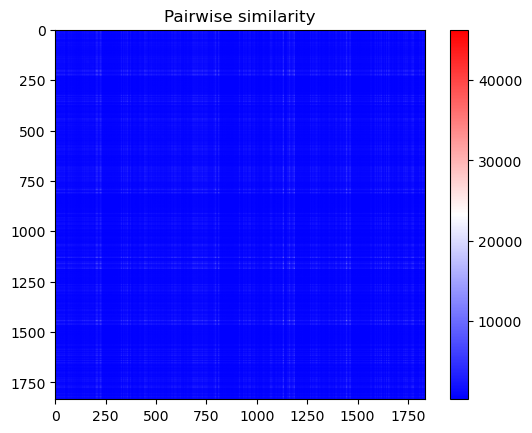

In [41]:
embs = []
for i, batch in zip(range(5), plain_loader):
    with torch.no_grad():
        z = model.encoder_q(batch)
        embs.append(z)
embs = torch.cat(embs)  # shape: [N, D], N ~ 20
sims = torch.mm(embs, embs.t())  # [N, N]
import matplotlib.pyplot as plt
plt.imshow(sims.cpu(), cmap='bwr'); plt.colorbar(); plt.title("Pairwise similarity"); plt.show()

In [ ]:
from src.data import augment_brep_data
batch_q = next(iter(plain_loader))

x = batch_q[0]  # data
reps = []
for _ in range(10):
    q = augment_brep_data(x)  # вручную вызывай augment
    z = model.encoder_q(q)
    z = F.normalize(z, dim=1)
    reps.append(z)
reps = torch.cat(reps, dim=0)
sims = reps @ reps.T
print(sims)

ValueError: too many values to unpack (expected 2)

In [23]:
import torch
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from torch_geometric.nn import global_mean_pool
import json
from src.config import MODELS_DIR, PROCESSED_DATA_DIR

# Настройка путей
BREP_NPZ_DIR = PROCESSED_DATA_DIR / "features" / "brep"
CHECKPOINT = MODELS_DIR / 'brep-moco-epoch=16-train_contrastive_loss=17.5805.ckpt'
embeddings_dir = PROCESSED_DATA_DIR / "embeddings"
embeddings_dir.mkdir(parents=True, exist_ok=True)
STATS_BREPNET = PROCESSED_DATA_DIR / "dataset_stats.json"

# Загрузка модели
print("Загрузка модели...")
trained_model = BRepMoCoAutoencoder.load_from_checkpoint(CHECKPOINT)
trained_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model.to(device)

# Загрузка статистики для стандартизации
with open(STATS_BREPNET, encoding="utf-8") as f:
    stats = json.load(f)

def standardize_features(feature_tensor, feature_stats):
    means = np.array([s["mean"] for s in feature_stats])
    sds = np.array([s["standard_deviation"] for s in feature_stats])
    eps = 1e-7
    means_x = np.expand_dims(means, axis=0)
    sds_x = np.expand_dims(sds, axis=0)
    return ((feature_tensor - means_x) / (sds_x + eps)).astype(np.float32)

def extract_embedding_from_npz(npz_path):
    """Извлечение эмбеддинга из NPZ файла"""
    data_dict = np.load(npz_path, allow_pickle=True)
    
    # Загрузка и стандартизация данных
    vertices = data_dict["vertex"].astype(np.float32)
    edges = standardize_features(
        data_dict["edge_features"].astype(np.float32),
        stats["feature_standardization"]["edge_features"]
    )
    faces = standardize_features(
        data_dict["face_features"].astype(np.float32),
        stats["feature_standardization"]["face_features"]
    )
    edge_to_vertex = data_dict["edge_to_vertex"].astype(np.int64)
    face_to_edge = data_dict["face_to_edge"].astype(np.int64)
    
    # Преобразование в тензоры
    vertices_t = torch.from_numpy(vertices).to(device)
    edges_t = torch.from_numpy(edges).to(device)
    faces_t = torch.from_numpy(faces).to(device)
    edge_to_vertex_t = torch.from_numpy(edge_to_vertex).to(device)
    face_to_edge_t = torch.from_numpy(face_to_edge).to(device)
    
    # Создание batch-совместимого объекта
    from types import SimpleNamespace
    data = SimpleNamespace(
        vertices=vertices_t,
        edges=edges_t,
        faces=faces_t,
        edge_to_vertex=edge_to_vertex_t,
        face_to_edge=face_to_edge_t,
        faces_batch=torch.zeros(faces_t.size(0), dtype=torch.long, device=device)
    )
    
    # Извлечение эмбеддинга
    with torch.no_grad():
        face_features = trained_model.encoder_q(data)
        
        if face_features.numel() == 0:
            return None
        
        embedding = global_mean_pool(
            face_features,
            data.faces_batch,
            size=1
        ).cpu().numpy()
    
    return embedding.squeeze()

# Получаем список test NPZ файлов
with open(STATS_BREPNET, encoding="utf-8") as f:
    dataset_info = json.load(f)

test_files = list(BREP_NPZ_DIR.glob("*.npz"))
print(f"Найдено {len(test_files)} тестовых файлов")

# Извлечение эмбеддингов
for idx, filename in enumerate(tqdm(test_files, desc="Извлечение эмбеддингов")):
    npz_path = BREP_NPZ_DIR / filename
    
    if not npz_path.exists():
        print(f"Файл не найден: {npz_path}")
        continue
    
    emb = extract_embedding_from_npz(npz_path)
    
    if emb is not None:
        np.savez(embeddings_dir / f"{filename.stem}.npz", emb)

print(f"\nСохранено {len(list(embeddings_dir.glob('*.npz')))} эмбеддингов в {embeddings_dir}")

Загрузка модели...
Найдено 132 тестовых файлов


d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.5.3


Извлечение эмбеддингов:   0%|          | 0/132 [00:00<?, ?it/s]


Сохранено 133 эмбеддингов в D:\workspace\projects\freelance\BRepMocAutoencoder\data\processed\embeddings


In [24]:
from src.metrics import eval_object_max

# Загрузка эмбеддингов
embedding_files = sorted(embeddings_dir.glob("*.npz"))

def load_embedding(path):
    return np.load(path, allow_pickle=True)["arr_0"].reshape(-1)

print(f"Вычисление метрик для {len(embedding_files)} эмбеддингов...")

# Вычисление метрик
metrics_df = eval_object_max(
    files=embedding_files,
    load_fn=load_embedding
)

print("\nРезультаты метрик:")
print(metrics_df.to_string(index=False))

# # Сохранение
# metrics_path = PROCESSED_DATA_DIR.parent / "reports" / "metrics.csv"
# metrics_path.parent.mkdir(exist_ok=True, parents=True)
# metrics_df.to_csv(metrics_path, index=False)

Вычисление метрик для 133 эмбеддингов...
Загрузка 133 эмбеддингов...


Loading:   0%|          | 0/133 [00:00<?, ?it/s]

Матрица эмбеддингов: (133, 256)
Вычисление метрик...


Processing batches:   0%|          | 0/5 [00:00<?, ?it/s]

Обработано 133 запросов

Результаты метрик:
 queries  recall@1  recall@5  recall@10     mAP   nDCG@5  nDCG@10  pos_mean  neg_mean   margin  cohens_d
     133  0.962406       1.0        1.0 0.97995 0.985141 0.985141       1.0  0.910193 0.089807  1.497503


In [25]:
from src.searcher import search_top_k, search_top_k_cosine
import random

print("Поисковик загружен")
print(f"Директория с эмбеддингами: {embeddings_dir}")
print(f"Всего эмбеддингов: {len(list(embeddings_dir.glob('*.npz')))}")

Поисковик загружен
Директория с эмбеддингами: D:\workspace\projects\freelance\BRepMocAutoencoder\data\processed\embeddings
Всего эмбеддингов: 133


In [29]:
# Выбираем случайный запрос
all_embeddings = sorted(list(embeddings_dir.glob("*.npz")))
query_file = all_embeddings[17]
query_stem = query_file.stem

print(f"Запрос: {query_stem}")
print("="*60)

# Поиск Top-10 по евклидову расстоянию
results_euclidean = search_top_k(
    embeddings_dir=embeddings_dir,
    query_stem=query_stem,
    top_k=10,
    embedding_key="arr_0"
)

print("\nTop-10 (Евклидово расстояние):")
print(results_euclidean.to_string(index=True))

Запрос: 42. Silencer Fix-04.prt

Top-10 (Евклидово расстояние):
                     model     score
0  42. Silencer Fix-04.prt  0.000000
1  42. Silencer Fix-05.prt  0.972193
2  42. Silencer Fix-03.prt  1.089003
3  42. Silencer Fix-07.prt  1.336417
4  42. Silencer Fix-06.prt  1.336417
5  42. Silencer Fix-10.prt  1.797902
6  42. Silencer Fix-08.prt  1.964972
7  42. Silencer Fix-09.prt  2.280875
8    Камера газовая 10.prt  3.624924
9     Камера газовая 8.prt  3.739226


In [30]:
results_cosine = search_top_k_cosine(
    embeddings_dir=embeddings_dir,
    query_stem=query_stem,
    top_k=20,
    embedding_key="arr_0"
)

print("\nTop-10 (Косинусное сходство):")
print(results_cosine.to_string(index=True))


Top-10 (Косинусное сходство):
                               model    cosine
0            42. Silencer Fix-04.prt  1.000000
1            42. Silencer Fix-05.prt  0.997926
2            42. Silencer Fix-03.prt  0.997529
3            42. Silencer Fix-07.prt  0.996811
4            42. Silencer Fix-06.prt  0.996811
5            42. Silencer Fix-08.prt  0.996685
6            42. Silencer Fix-09.prt  0.995526
7            42. Silencer Fix-10.prt  0.994258
8              Камера газовая 10.prt  0.976353
9               Камера газовая 8.prt  0.972692
10              Камера газовая 9.prt  0.972361
11  Зацеп трубки направляющий 10.prt  0.956639
12                     Защелка 1.prt  0.952741
13                       Защелка.prt  0.952315
14                     Защелка 4.prt  0.948356
15   Зацеп трубки направляющий 1.prt  0.947970
16           42. Silencer Fix-02.prt  0.946794
17                     Защелка 7.prt  0.946127
18           42. Silencer Fix-01.prt  0.946004
19                     Защелк